# Data Training and Prediction

Train models and predict the test data

In [99]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [100]:
# Read data and separate into features and target
df = pd.read_csv('processed_train_data.csv')
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

# Model Selection
To build a stacking model with 3 different non-parametric models, we can test the performance of the following models:
- kNeighborsClassifier
- DecisionTreeClassifier
- RandomForestClassifier
- BaggingClassifier
- GradientBoostingClassifier
- GaussianProcessClassifier
- SVC

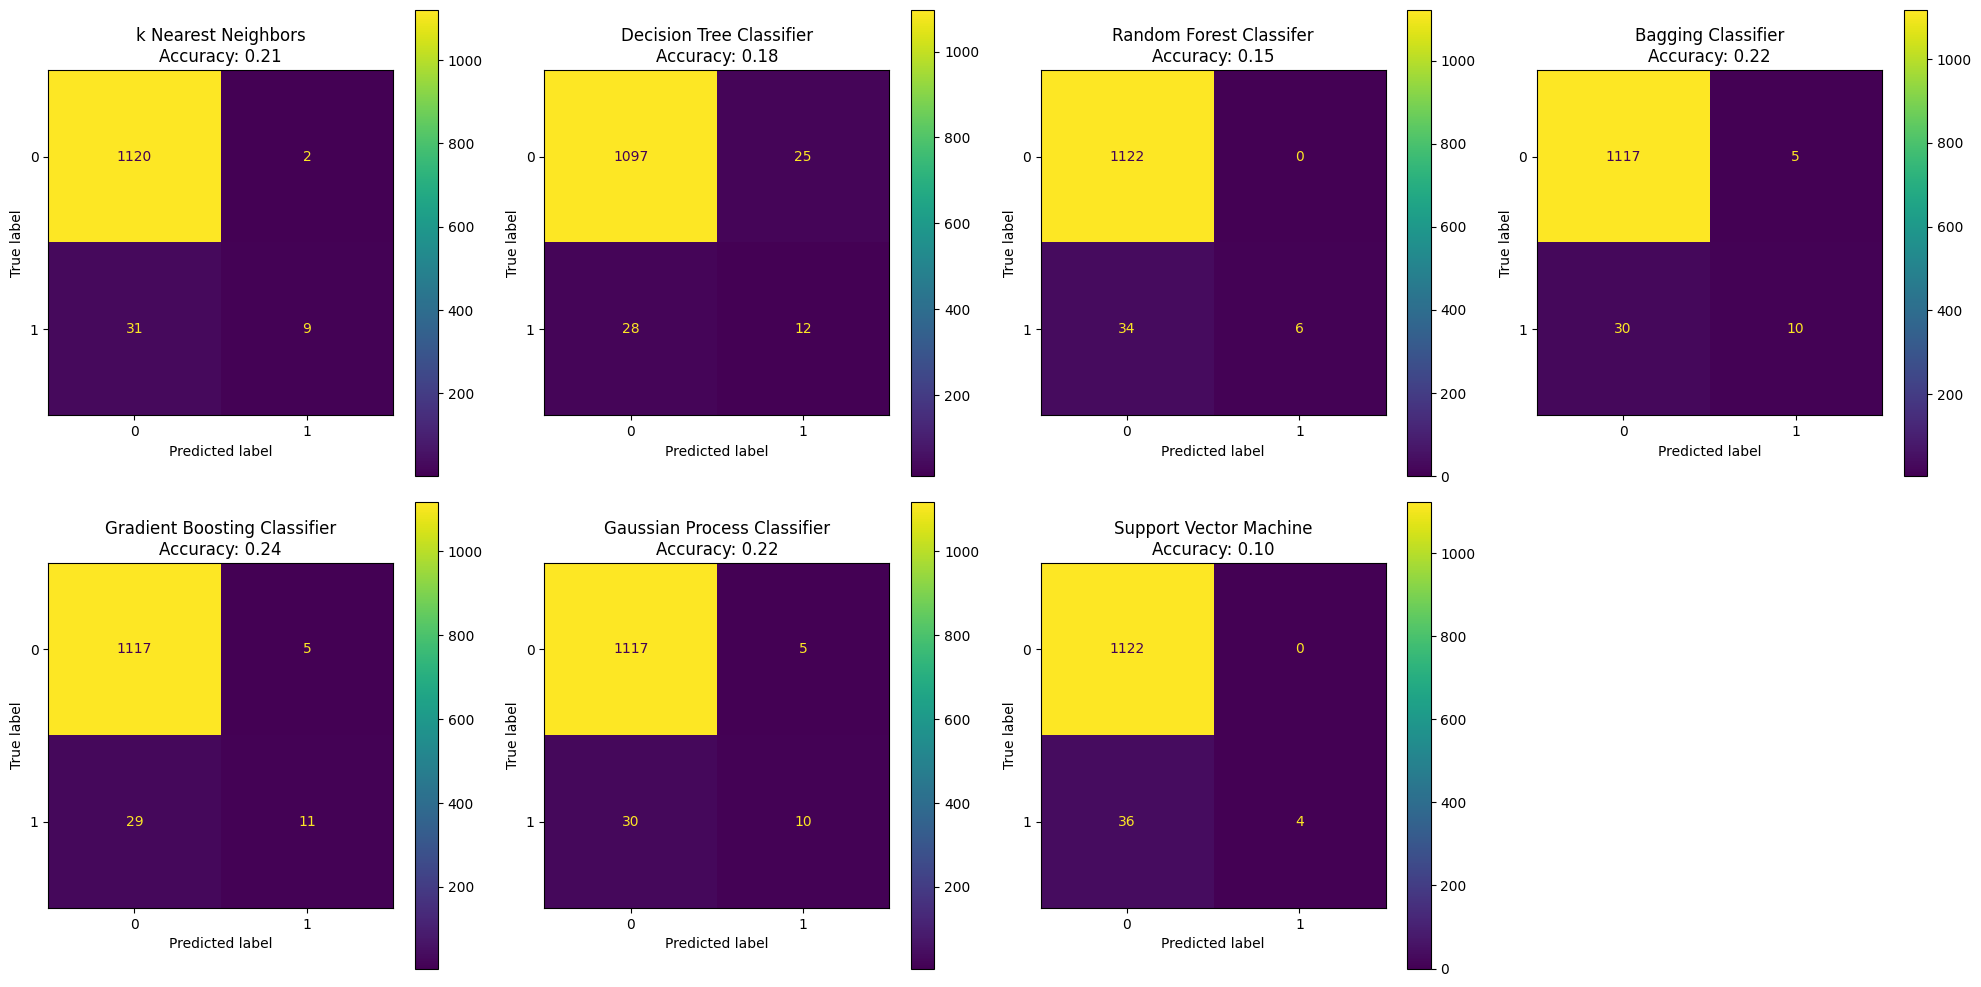

In [101]:
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
bc = BaggingClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
gpc = GaussianProcessClassifier(random_state=42)
svc = SVC(random_state=42)

models = [knn, dtc, rfc, bc, gbc, gpc, svc]
model_names = ["k Nearest Neighbors", "Decision Tree Classifier", "Random Forest Classifer", "Bagging Classifier", 
               "Gradient Boosting Classifier", "Gaussian Process Classifier", "Support Vector Machine"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

fig, axes = plt.subplots(2, 4, figsize=(20, 10)) 
axes = axes.flatten()

for idx, (model, name) in enumerate(zip(models, model_names)):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    acc = cm[1][1] / (cm[0][1] + cm[1][0] + cm[1][1])
    disp.plot(ax=axes[idx])
    axes[idx].set_title(f'{name}\nAccuracy: {acc:.2f}')
        
for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

The best performing models are:

- Decision Tree Classifier
- Bagging Classifier
- Gradient Boosting Classifier
- Gaussian Process Classifier

# Create Stacking Model
Using the models above, we can create a stacking model and test its performance using cross-validation.

In [97]:
base_models = [
    ("model1", DecisionTreeClassifier(random_state=42)),
    ("model2", BaggingClassifier(random_state=42)),
    ("model3", GradientBoostingClassifier(random_state=42)),
    ("model4", GaussianProcessClassifier(random_state=42))
]

meta_learner = LogisticRegression(random_state=42)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner, cv=5)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    acc = stacking_model.score(X_test, y_test)
    
    # Store results
    cv_results.append({
        "Accuracy": acc,
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    })

# Report results
for i, result in enumerate(cv_results):
    print(f"Fold {i+1}: Accuracy = {result['Accuracy']}")
    print("Confusion Matrix:")
    print(result["Confusion Matrix"])

Fold 1: Accuracy = 0.9664371772805508
Confusion Matrix:
[[1116    6]
 [  33    7]]
Fold 2: Accuracy = 0.9655765920826161
Confusion Matrix:
[[1114    8]
 [  32    8]]
Fold 3: Accuracy = 0.970714900947459
Confusion Matrix:
[[1119    3]
 [  31    8]]
Fold 4: Accuracy = 0.9681309216192937
Confusion Matrix:
[[1120    2]
 [  35    4]]
Fold 5: Accuracy = 0.967269595176572
Confusion Matrix:
[[1116    5]
 [  33    7]]


# Predict the test data

Using the model above, we can now predict the test data.

In [ ]:
test_data = pd.read_csv('processed_test_data.csv')
test_data['Bankrupt?'] = stacking_model.predict(test_data)
test_data.to_csv('predicted_test_data.csv', index=False)